# Working with 10-K Data

In [129]:
#import edgar
#This module pulls the SEC files for companies

#Pick the company
#company = edgar.Company("Oracle Corp", "0001341439")

#Get the filings, in this case the 10K
#tree = company.get_all_filings(filingType = "10-K")

#Pull the latest 5 documents
#docs = edgar.getDocuments(tree, noOfDocuments=5)

from edgar import Company, TXTML
import edgar
company = Company("Oracle Corp", "0001341439")
tree = company.get_all_filings(filing_type = "10-K")
docs = Company.get_documents(tree, no_of_documents=5)


In [130]:
#Let's see the first document
doc = docs[0]
print(doc)
print(type(doc))

<Element sec-document at 0x10cba4c67f0>
<class 'lxml.html.HtmlElement'>


In [131]:
import re
#Using regular expressions we can find the places where Item 1A. is referenced, the risk section
#Notice the backlash has to be used for the period to escape it
#There are two places we find it, the table of contents and the header
sample_text = TXTML.parse_full_10K(doc)
print(re.findall(re.compile('Item 1A\.'), sample_text))

['Item 1A.', 'Item 1A.']


In [132]:
#A better way is to search and find the elements. This will give location as well as matched string
for match in re.finditer('Item 1A\.', sample_text):
    print(match)

<re.Match object; span=(46181, 46189), match='Item 1A.'>
<re.Match object; span=(120229, 120237), match='Item 1A.'>


In [133]:
#We can grab the span as so
print(match.span())

(120229, 120237)


In [134]:
#We can also generalize the regular expression to all items
matches = list(re.finditer(re.compile('Item [0-9][A-Z]*\.'), sample_text))
print(matches)

[<re.Match object; span=(46153, 46160), match='Item 1.'>, <re.Match object; span=(46181, 46189), match='Item 1A.'>, <re.Match object; span=(46215, 46223), match='Item 1B.'>, <re.Match object; span=(46262, 46270), match='Item 1C.'>, <re.Match object; span=(46297, 46304), match='Item 2.'>, <re.Match object; span=(46328, 46335), match='Item 3.'>, <re.Match object; span=(46366, 46373), match='Item 4.'>, <re.Match object; span=(46430, 46437), match='Item 5.'>, <re.Match object; span=(46559, 46566), match='Item 6.'>, <re.Match object; span=(46590, 46597), match='Item 7.'>, <re.Match object; span=(46696, 46704), match='Item 7A.'>, <re.Match object; span=(46776, 46783), match='Item 8.'>, <re.Match object; span=(46840, 46847), match='Item 9.'>, <re.Match object; span=(46945, 46953), match='Item 9A.'>, <re.Match object; span=(56165, 56172), match='Item 1.'>, <re.Match object; span=(120229, 120237), match='Item 1A.'>, <re.Match object; span=(197486, 197494), match='Item 1B.'>, <re.Match object; s

In [135]:
#The first index of the mathces will be the actual string
print(matches[0][0])

Item 1.


In [136]:
#Let's find all matches for Item 1A.
item_matches = [i for i in range(len(matches)) if matches[i][0] == 'Item 1A.']
print(item_matches)

[1, 15]


In [137]:
#We'll take the latest index as the start of the actual section
start = max(item_matches)
#And the end will be the index after
end = start+1

In [138]:
#Let's also get the end span of the first item and the beginning of the span for the second one to find the text between
start = matches[start].span()[1]
end = matches[end].span()[0]
print(start)
print(end)

120237
197486


In [139]:
#And let's inspect the actual text
print(sample_text[start:end])

	Risk Factors We operate in rapidly changing economic and technological environments that present numerous risks, many of which are driven by factors that we cannot control or predict. The following discussion, as well as our discussion in Item 7 Management’s Discussion and Analysis of Financial Condition and Results of Operations, highlights some of these risks. The risks described below are not exhaustive and you should carefully consider these risks and uncertainties before investing in our securities. Business and Operational Risks We may be unsuccessful in developing and selling new products and services, integrating acquired products and services and enhancing our existing products and services.   Our industry is characterized by rapid technological advances, intense competition, changing delivery models, evolving standards in communications infrastructure, increasingly sophisticated customer needs and frequent new product introductions and enhancements. We have continued to refr

In [140]:
#Now put it in a function
def pull_risk_section(text):
    matches = list(re.finditer(re.compile('Item [0-9][A-Z]*\.'), text))
    start = max([i for i in range(len(matches)) if matches[i][0] == 'Item 1A.'])
    end = start+1
    start = matches[start].span()[1]
    end = matches[end].span()[0]
    return text[start:end]
print(pull_risk_section(sample_text))

	Risk Factors We operate in rapidly changing economic and technological environments that present numerous risks, many of which are driven by factors that we cannot control or predict. The following discussion, as well as our discussion in Item 7 Management’s Discussion and Analysis of Financial Condition and Results of Operations, highlights some of these risks. The risks described below are not exhaustive and you should carefully consider these risks and uncertainties before investing in our securities. Business and Operational Risks We may be unsuccessful in developing and selling new products and services, integrating acquired products and services and enhancing our existing products and services.   Our industry is characterized by rapid technological advances, intense competition, changing delivery models, evolving standards in communications infrastructure, increasingly sophisticated customer needs and frequent new product introductions and enhancements. We have continued to refr

In [141]:
#We also want to get rid of any unneeded characters
def pull_risk_section(text):
    text = re.sub('\n', ' ', text)
    text = re.sub('\xa0', ' ', text)
    matches = list(re.finditer(re.compile('Item [0-9][A-Z]*\.'), text))
    start = max([i for i in range(len(matches)) if matches[i][0] == 'Item 1A.'])
    end = start+1
    start = matches[start].span()[1]
    end = matches[end].span()[0]
    text = text[start:end]
    return text
risk_section = pull_risk_section(sample_text)
print(risk_section)

	Risk Factors We operate in rapidly changing economic and technological environments that present numerous risks, many of which are driven by factors that we cannot control or predict. The following discussion, as well as our discussion in Item 7 Management’s Discussion and Analysis of Financial Condition and Results of Operations, highlights some of these risks. The risks described below are not exhaustive and you should carefully consider these risks and uncertainties before investing in our securities. Business and Operational Risks We may be unsuccessful in developing and selling new products and services, integrating acquired products and services and enhancing our existing products and services.   Our industry is characterized by rapid technological advances, intense competition, changing delivery models, evolving standards in communications infrastructure, increasingly sophisticated customer needs and frequent new product introductions and enhancements. We have continued to refr

In [142]:
#Let's also make a function for pulling the 10-Ks
def pull_10K(company_name, company_id):
    company = Company(company_name, company_id)
    tree = company.get_all_filings(filing_type = "10-K")
    docs = company.get_documents(tree, no_of_documents=5)
    return docs
documents = pull_10K("Oracle Corp", "0001341439")
print(documents[0])

<Element sec-document at 0x10cba48d8a0>


In [143]:
#Let's see the functions in action
documents = pull_10K("Oracle Corp", "0001341439")
risk_sections = [pull_risk_section(TXTML.parse_full_10K(document)) for document in documents]
print(risk_sections[0])

	Risk Factors We operate in rapidly changing economic and technological environments that present numerous risks, many of which are driven by factors that we cannot control or predict. The following discussion, as well as our discussion in Item 7 Management’s Discussion and Analysis of Financial Condition and Results of Operations, highlights some of these risks. The risks described below are not exhaustive and you should carefully consider these risks and uncertainties before investing in our securities. Business and Operational Risks We may be unsuccessful in developing and selling new products and services, integrating acquired products and services and enhancing our existing products and services.   Our industry is characterized by rapid technological advances, intense competition, changing delivery models, evolving standards in communications infrastructure, increasingly sophisticated customer needs and frequent new product introductions and enhancements. We have continued to refr

In [144]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

#Let's grab word counts like we did prior
stemmer = nltk.stem.SnowballStemmer('english')
risk_sections = [stemmer.stem(risk_section) for risk_section in risk_sections]
vectorizer = CountVectorizer(stop_words='english')
counts = vectorizer.fit_transform(risk_sections)
counts = pd.DataFrame(counts.toarray(),columns=vectorizer.get_feature_names_out()).transpose()
counts.columns = [2018,2017,2016,2015,2014]
print(counts)

       2018  2017  2016  2015  2014
10        0     0     1     0     0
118       0     0     1     0     0
12        0     1     0     0     0
137       0     0     1     0     0
140       1     0     0     0     0
...     ...   ...   ...   ...   ...
write     0     0     0     1     1
year      3     2     2     2     4
years     4     4     4     4     4
yen       1     1     1     1     1
yield     0     1     1     0     0

[2151 rows x 5 columns]


In [145]:
#In this case we don't need to turn it into frequency if we want to also penalize for different length risk sections
print(sum((counts[2018]-counts[2017])**2)**.5)

49.31531202375181


In [146]:
#We can apply the difference in a horizontal manner
print(counts.diff(axis=1).dropna(axis=1))

       2017  2016  2015  2014
10        0     1    -1     0
118       0     1    -1     0
12        1    -1     0     0
137       0     1    -1     0
140      -1     0     0     0
...     ...   ...   ...   ...
write     0     0     1     0
year     -1     0     0     2
years     0     0     0     0
yen       0     0     0     0
yield     1     0    -1     0

[2151 rows x 4 columns]


In [147]:
#And then get the distance
print((counts.diff(axis=1).dropna(axis=1)**2).sum()**.5)

2017    49.315312
2016    42.965102
2015    39.433488
2014    60.621778
dtype: float64


In [148]:
#Create a function for the distance
def find_distance(risk_sections):
    stemmer = nltk.stem.SnowballStemmer('english')
    risk_sections = [stemmer.stem(risk_section) for risk_section in risk_sections]
    vectorizer = CountVectorizer(stop_words='english')
    counts = vectorizer.fit_transform(risk_sections)
    counts = pd.DataFrame(counts.toarray(),columns=vectorizer.get_feature_names_out()).transpose()
    counts.columns = [2018,2017,2016,2015,2014]
    return (counts.diff(axis=1).dropna(axis=1)**2).sum()**.5
print(find_distance(risk_sections))

2017    49.315312
2016    42.965102
2015    39.433488
2014    60.621778
dtype: float64


# Applications of TF-IDF

In [149]:
import numpy as np
#One thing we can do is take the log of the number of terms
tf_log = np.log(1 + counts)
print(tf_log)

           2018      2017      2016      2015      2014
10     0.000000  0.000000  0.693147  0.000000  0.000000
118    0.000000  0.000000  0.693147  0.000000  0.000000
12     0.000000  0.693147  0.000000  0.000000  0.000000
137    0.000000  0.000000  0.693147  0.000000  0.000000
140    0.693147  0.000000  0.000000  0.000000  0.000000
...         ...       ...       ...       ...       ...
write  0.000000  0.000000  0.000000  0.693147  0.693147
year   1.386294  1.098612  1.098612  1.098612  1.609438
years  1.609438  1.609438  1.609438  1.609438  1.609438
yen    0.693147  0.693147  0.693147  0.693147  0.693147
yield  0.000000  0.693147  0.693147  0.000000  0.000000

[2151 rows x 5 columns]


In [150]:
#Inverse Document Frequency

#First find the number of documents with each term
n = (counts > 0).sum(axis=1)

#Then divide that by total number of documents and take the log of it
idf = np.log(5 / n)
print(idf)

10       1.609438
118      1.609438
12       1.609438
137      1.609438
140      1.609438
           ...   
write    0.916291
year     0.000000
years    0.000000
yen      0.000000
yield    0.916291
Length: 2151, dtype: float64


In [151]:
tf_idf = tf_log.multiply(idf, axis=0)
print(tf_idf)

           2018      2017      2016      2015      2014
10     0.000000  0.000000  1.115577  0.000000  0.000000
118    0.000000  0.000000  1.115577  0.000000  0.000000
12     0.000000  1.115577  0.000000  0.000000  0.000000
137    0.000000  0.000000  1.115577  0.000000  0.000000
140    1.115577  0.000000  0.000000  0.000000  0.000000
...         ...       ...       ...       ...       ...
write  0.000000  0.000000  0.000000  0.635124  0.635124
year   0.000000  0.000000  0.000000  0.000000  0.000000
years  0.000000  0.000000  0.000000  0.000000  0.000000
yen    0.000000  0.000000  0.000000  0.000000  0.000000
yield  0.000000  0.635124  0.635124  0.000000  0.000000

[2151 rows x 5 columns]


In [152]:
#Now we want to try cosine similarity to compare
#Notice the interesting pattern here of similarity getting smaller and smaller as the years are farther apart
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(tf_idf.transpose())
similarity = pd.DataFrame(similarity, index=[2018,2017,2016,2015,2014],columns=[2018,2017,2016,2015,2014])
print(similarity)

          2018      2017      2016      2015      2014
2018  1.000000  0.348919  0.091084  0.019960  0.018756
2017  0.348919  1.000000  0.277908  0.079477  0.017675
2016  0.091084  0.277908  1.000000  0.278097  0.064259
2015  0.019960  0.079477  0.278097  1.000000  0.229527
2014  0.018756  0.017675  0.064259  0.229527  1.000000


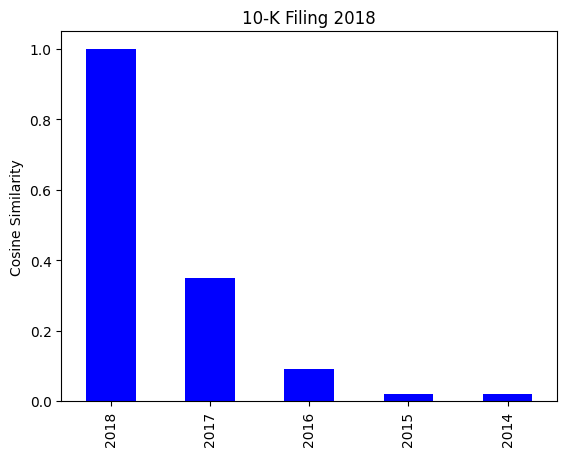

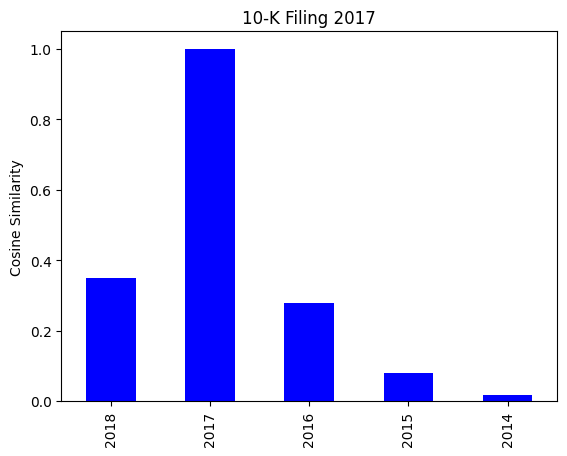

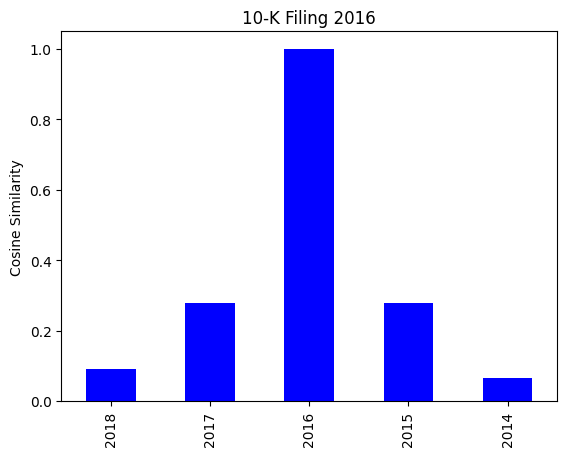

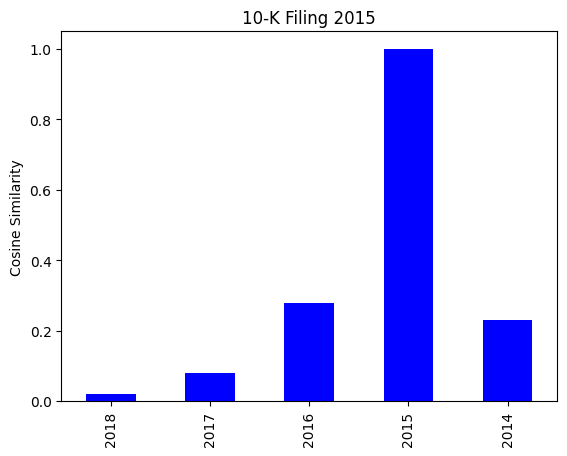

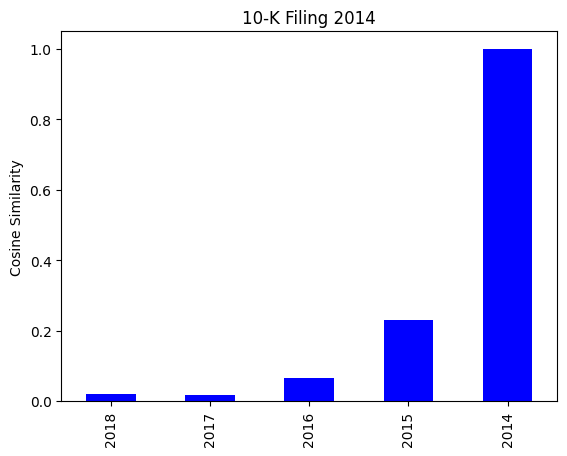

In [153]:
import matplotlib.pyplot as plt

for yr in similarity.index:
    similarity.loc[yr].plot(kind='bar', color='blue')
    plt.title("10-K Filing {}".format(yr))
    plt.ylabel("Cosine Similarity")
    plt.show()

In [154]:
yoy_similarity = pd.Series([similarity.loc[x,x+1] for x in [2017,2016,2015,2014]])
yoy_similarity.index = ['{}-{}'.format(x,x+1) for x in [2017,2016,2015,2014]]
print(yoy_similarity)

2017-2018    0.348919
2016-2017    0.277908
2015-2016    0.278097
2014-2015    0.229527
dtype: float64


In [155]:
#Let's see the most impactful words that either came on in the latest or were much more frequent
#As well as the opposite
print(tf_idf.diff(axis=1).dropna(axis=1).iloc[:,0].sort_values().head(10))
print()
print()
print(tf_idf.diff(axis=1).dropna(axis=1).iloc[:,0].sort_values(ascending=False).head(10))

ampere             -3.131822
2024               -2.590290
regulated          -2.590290
tiktok             -2.590290
interoperability   -2.231155
devices            -2.231155
options            -2.231155
cehrt              -2.231155
ai                 -1.905373
operation          -1.768148
Name: 2017, dtype: float64


resurgence     1.768148
site           1.768148
2022           1.270249
12             1.115577
excise         1.115577
escalating     1.115577
retaliatory    1.115577
attrition      1.115577
december       1.115577
variants       1.115577
Name: 2017, dtype: float64


In [156]:
#We see these words were specific only to one filing
#print(counts.loc['autonomous'])
#print()
#print(counts.loc['turkey'])

In [157]:
print(counts.loc['software'])
print()
print(tf_idf.loc['software'])

2018     5
2017     8
2016    11
2015    11
2014    14
Name: software, dtype: int64

2018    0.0
2017    0.0
2016    0.0
2015    0.0
2014    0.0
Name: software, dtype: float64


In [158]:
print(tf_log.loc['software'])
print()
print(idf.loc['software'])

2018    1.791759
2017    2.197225
2016    2.484907
2015    2.484907
2014    2.708050
Name: software, dtype: float64

0.0


# Risk Analysis

In [159]:
#An application of looking at these things is to see if there are companies that are becoming competitors
#Only in the most recent filing amazon comes up, but Oracle constantly mentions cloud
print(counts.loc["amazon"])
print(counts.loc["cloud"])
print()
print()
#Because cloud is mentioned in every documents it has no importance in the tf_idf
print(tf_idf.loc["amazon"])
print(tf_idf.loc["cloud"])

2018    1
2017    1
2016    0
2015    0
2014    0
Name: amazon, dtype: int64
2018    67
2017    66
2016    62
2015    59
2014    59
Name: cloud, dtype: int64


2018    0.635124
2017    0.635124
2016    0.000000
2015    0.000000
2014    0.000000
Name: amazon, dtype: float64
2018    0.0
2017    0.0
2016    0.0
2015    0.0
2014    0.0
Name: cloud, dtype: float64


In [160]:
#Pull the risk sections of Amazon and Oracle
documents_oracle = pull_10K("Oracle Corp", "0001341439")
documents_amazon = pull_10K("Amazon Com Inc", "0001018724")

risk_sections_oracle = [pull_risk_section(TXTML.parse_full_10K(document)) for document in documents_oracle]
risk_sections_amazon = [pull_risk_section(TXTML.parse_full_10K(document)) for document in documents_amazon]


In [161]:
#Parse each risk section
stemmer = nltk.stem.SnowballStemmer('english')
vectorizer = CountVectorizer(stop_words='english')
counts_oracle = vectorizer.fit_transform(risk_sections_oracle)
counts_oracle = pd.DataFrame(counts_oracle.toarray(),columns=vectorizer.get_feature_names_out()).transpose()
counts_oracle.columns = [2018,2017,2016,2015,2014]


counts_amazon = vectorizer.fit_transform(risk_sections_amazon)
counts_amazon = pd.DataFrame(counts_amazon.toarray(),columns=vectorizer.get_feature_names_out()).transpose()
counts_amazon.columns = [2018,2017,2016,2015,2014]


counts_amazon = counts_amazon.stack().reset_index()
counts_oracle = counts_oracle.stack().reset_index()

In [162]:
counts_amazon.columns = ["Word", "Time Period", "Count"]
counts_amazon["Company"] = "Amazon"
counts_oracle.columns = ["Word", "Time Period", "Count"]
counts_oracle["Company"] = "Oracle"
counts = pd.concat([counts_amazon, counts_oracle])
print(counts)

        Word  Time Period  Count Company
0         10         2018      1  Amazon
1         10         2017      1  Amazon
2         10         2016      1  Amazon
3         10         2015      1  Amazon
4         10         2014      1  Amazon
...      ...          ...    ...     ...
10750  yield         2018      0  Oracle
10751  yield         2017      1  Oracle
10752  yield         2016      1  Oracle
10753  yield         2015      0  Oracle
10754  yield         2014      0  Oracle

[17825 rows x 4 columns]


In [163]:
#Now that we are combining the two together, something to consider is how idf will be impacted
#Before, it was a huge difference when Oracle had Amazon added to the risk section
#Now, however, the word will look much less important if IDF is done over the full document
print(counts[counts["Word"] == "amazon"])
print()
print()
#Likewise, Oracle as a word will now be more important because it is not featured in Amazon's 10-K
print(counts[counts["Word"] == "oracle"])

       Word  Time Period  Count Company
370  amazon         2018      6  Amazon
371  amazon         2017      7  Amazon
372  amazon         2016      5  Amazon
373  amazon         2015      5  Amazon
374  amazon         2014      4  Amazon
650  amazon         2018      1  Oracle
651  amazon         2017      1  Oracle
652  amazon         2016      0  Oracle
653  amazon         2015      0  Oracle
654  amazon         2014      0  Oracle


        Word  Time Period  Count Company
6820  oracle         2018     22  Oracle
6821  oracle         2017     20  Oracle
6822  oracle         2016     25  Oracle
6823  oracle         2015     22  Oracle
6824  oracle         2014     26  Oracle


In [164]:
print(counts.columns)
counts = counts.set_index(["Company", "Time Period", "Word"])["Count"].unstack().transpose().fillna(0)
print(counts)

Index(['Word', 'Time Period', 'Count', 'Company'], dtype='object')
Company     Amazon                     Oracle                    
Time Period   2014 2015 2016 2017 2018   2014 2015 2016 2017 2018
Word                                                             
10             1.0  1.0  1.0  1.0  1.0    0.0  0.0  1.0  0.0  0.0
11             1.0  1.0  1.0  1.0  1.0    0.0  0.0  0.0  0.0  0.0
118            0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  0.0  0.0
12             1.0  1.0  1.0  1.0  1.0    0.0  0.0  0.0  1.0  0.0
13             1.0  1.0  1.0  1.0  1.0    0.0  0.0  0.0  0.0  0.0
...            ...  ...  ...  ...  ...    ...  ...  ...  ...  ...
year           2.0  2.0  2.0  2.0  2.0    4.0  2.0  2.0  2.0  3.0
years          0.0  0.0  0.0  1.0  0.0    4.0  4.0  4.0  4.0  4.0
yen            1.0  1.0  1.0  1.0  1.0    1.0  1.0  1.0  1.0  1.0
yield          0.0  0.0  0.0  0.0  0.0    0.0  0.0  1.0  1.0  0.0
zone           2.0  2.0  2.0  1.0  1.0    0.0  0.0  0.0  0.0  0.0

[2597 ro

In [165]:
tf_log = np.log(counts + 1)

n = (counts > 0).sum(axis=1)

idf = np.log(len(counts.columns) / n)
tf_idf = tf_log.multiply(idf, axis=0)
print(tf_idf)

Company        Amazon                                            Oracle  \
Time Period      2014      2015      2016      2017      2018      2014   
Word                                                                      
10           0.354077  0.354077  0.354077  0.354077  0.354077  0.000000   
11           0.480453  0.480453  0.480453  0.480453  0.480453  0.000000   
118          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12           0.354077  0.354077  0.354077  0.354077  0.354077  0.000000   
13           0.480453  0.480453  0.480453  0.480453  0.480453  0.000000   
...               ...       ...       ...       ...       ...       ...   
year         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
years        0.000000  0.000000  0.000000  0.354077  0.000000  0.822142   
yen          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
yield        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
zone         0.761500  0.

In [166]:
#Let's find cosine similarity
similarity = cosine_similarity(tf_idf.transpose())
similarity = pd.DataFrame(similarity, index=tf_idf.columns,columns=tf_idf.columns)
print(similarity)

Company                Amazon                                          \
Time Period              2014      2015      2016      2017      2018   
Company Time Period                                                     
Amazon  2014         1.000000  0.916275  0.828744  0.765929  0.734234   
        2015         0.916275  1.000000  0.905923  0.826003  0.792413   
        2016         0.828744  0.905923  1.000000  0.869942  0.835065   
        2017         0.765929  0.826003  0.869942  1.000000  0.960674   
        2018         0.734234  0.792413  0.835065  0.960674  1.000000   
Oracle  2014         0.027367  0.027599  0.026526  0.033802  0.033438   
        2015         0.014541  0.012962  0.010976  0.016027  0.016505   
        2016         0.013283  0.013326  0.015324  0.021772  0.022492   
        2017         0.019688  0.016046  0.022249  0.024596  0.025258   
        2018         0.020275  0.022074  0.026993  0.039154  0.039639   

Company                Oracle                     

In [167]:
#And for each time period find the similarity between the two
yearly_sim = pd.Series([similarity.loc[("Amazon",x),("Oracle", x)] for x in [2018,2017,2016,2015,2014]], index=[2018,2017,2016,2015,2014])
print(yearly_sim)

2018    0.039639
2017    0.024596
2016    0.015324
2015    0.012962
2014    0.027367
dtype: float64


In [168]:
#We can see that amazon talks a lot more about the supply chain buzzwords
diff = tf_idf[("Amazon", 2018)] - tf_idf[("Oracle", 2018)]
print(diff.sort_values(ascending=False).head(10))
print()
print()
print(diff.sort_values().head(10))

Word
satellite       3.192061
fulfillment     2.202859
localization    2.157230
content         2.040930
sellers         2.040930
water           1.768148
perceptions     1.768148
online          1.722406
commercial      1.662094
prime           1.596030
dtype: float64


Word
ampere             -4.480624
ai                 -4.462309
2024               -3.705868
tiktok             -3.705868
cehrt              -3.192061
interoperability   -3.192061
generative         -2.529648
corruption         -2.529648
approximately      -2.529648
patient            -2.342823
dtype: float64


In [169]:
#We see that two new words that amazon began using stores, and omnichannel became a big difference
#One limitation is that words are split
#So if amazon mentions whole foods it would be split losing the actual importance of it being a company
#rather than two distinct words
i = diff.sort_values(ascending=False).head(5).index
print(counts.loc[i])

Company      Amazon                         Oracle                    
Time Period    2014  2015  2016  2017  2018   2014 2015 2016 2017 2018
Word                                                                  
satellite       0.0   0.0   0.0   0.0   3.0    0.0  0.0  0.0  0.0  0.0
fulfillment    19.0  23.0  23.0  23.0  23.0    0.0  0.0  0.0  0.0  0.0
localization    0.0   0.0   5.0   5.0   5.0    0.0  0.0  0.0  0.0  0.0
content        18.0  18.0  18.0  18.0  18.0    0.0  0.0  0.0  0.0  0.0
sellers        14.0  15.0  18.0  18.0  18.0    0.0  0.0  0.0  0.0  0.0


In [170]:
#This analysis can be useful to assess country level threats
#And correlations in the currency markets
#print(counts.loc[['yemen', 'turkey', 'china']])

# Applied Sentiment Analysis

In [171]:
#The word list has multiple sheets with tone descriptions for different words
#Something to note is that a word can be in multiple lists!
import pandas as pd
word_list = pd.read_excel("Data/LM Word List.xlsx", sheet_name="Negative",header=None)
print(word_list)

                 0
0          ABANDON
1        ABANDONED
2       ABANDONING
3      ABANDONMENT
4     ABANDONMENTS
...            ...
2350    WRONGDOING
2351   WRONGDOINGS
2352      WRONGFUL
2353    WRONGFULLY
2354       WRONGLY

[2355 rows x 1 columns]


In [172]:
#Create a matrix of word types and the words that match these types
word_list = []
for sentiment_class in ["Negative", "Positive", "Uncertainty", "Litigious",
                       "StrongModal", "WeakModal", "Constraining"]:
    sentiment_list = pd.read_excel("Data/LM Word List.xlsx", sheet_name=sentiment_class,header=None)
    sentiment_list.columns = ["Word"]
    sentiment_list["Word"] = sentiment_list["Word"].str.lower()
    sentiment_list[sentiment_class] = 1
    sentiment_list = sentiment_list.set_index("Word")[sentiment_class]
    word_list.append(sentiment_list)
word_list = pd.concat(word_list, axis=1, sort=True).fillna(0)
print(word_list)

              Negative  Positive  Uncertainty  Litigious  StrongModal  \
Word                                                                    
abandon            1.0       0.0          0.0        0.0          0.0   
abandoned          1.0       0.0          0.0        0.0          0.0   
abandoning         1.0       0.0          0.0        0.0          0.0   
abandonment        1.0       0.0          0.0        0.0          0.0   
abandonments       1.0       0.0          0.0        0.0          0.0   
...                ...       ...          ...        ...          ...   
wrongdoing         1.0       0.0          0.0        0.0          0.0   
wrongdoings        1.0       0.0          0.0        0.0          0.0   
wrongful           1.0       0.0          0.0        0.0          0.0   
wrongfully         1.0       0.0          0.0        0.0          0.0   
wrongly            1.0       0.0          0.0        0.0          0.0   

              WeakModal  Constraining  
Word      

In [173]:
#Examples of words which have multiple groups
print(word_list.loc[word_list.sum(axis=1) > 1])

            Negative  Positive  Uncertainty  Litigious  StrongModal  \
Word                                                                  
abrogate         1.0       0.0          0.0        1.0          0.0   
abrogated        1.0       0.0          0.0        1.0          0.0   
abrogates        1.0       0.0          0.0        1.0          0.0   
abrogating       1.0       0.0          0.0        1.0          0.0   
abrogation       1.0       0.0          0.0        1.0          0.0   
...              ...       ...          ...        ...          ...   
voided           1.0       0.0          0.0        1.0          0.0   
voiding          1.0       0.0          0.0        1.0          0.0   
volatile         1.0       0.0          1.0        0.0          0.0   
volatility       1.0       0.0          1.0        0.0          0.0   
willfully        1.0       0.0          0.0        1.0          0.0   

            WeakModal  Constraining  
Word                                 


In [174]:
#Let's reindex by negative words, as well as drop na, and see what negative words are mentioned
#We will look at percent frequency
tf_percent = counts / counts.sum()
negative_words = word_list[word_list["Negative"] == 1].index
negative_frequency = tf_percent.reindex(negative_words).dropna()
print(negative_frequency)

Company        Amazon                                            Oracle  \
Time Period      2014      2015      2016      2017      2018      2014   
Word                                                                      
accused      0.000244  0.000231  0.000219  0.000206  0.000205  0.000000   
adverse      0.001711  0.001846  0.001970  0.001856  0.001843  0.001705   
adversely    0.002688  0.002769  0.002846  0.003093  0.003072  0.007748   
allegations  0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
allege       0.000244  0.000231  0.000219  0.000206  0.000205  0.000000   
...               ...       ...       ...       ...       ...       ...   
vulnerable   0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
warned       0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
weaken       0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
weakening    0.000244  0.000231  0.000219  0.000206  0.000205  0.000155   
weakens      0.000000  0.

In [175]:
#There seems to be slightly higher negative term frequency for amazon, especially in the last few years
print("Year by Company negative word frequency")
print(negative_frequency.sum())
print()
print("Average company negative frequency")
print(negative_frequency.sum().groupby("Company").mean())

Year by Company negative word frequency
Company  Time Period
Amazon   2014           0.079179
         2015           0.079603
         2016           0.080123
         2017           0.079175
         2018           0.078640
Oracle   2014           0.069115
         2015           0.072479
         2016           0.070552
         2017           0.071511
         2018           0.074726
dtype: float64

Average company negative frequency
Company
Amazon    0.079344
Oracle    0.071677
dtype: float64


In [176]:
#Let's see what were the most common negative words in Amazon's latest risk section
negative_frequency.sort_values(by=("Amazon", 2018), ascending=False)

Company         Amazon                                            Oracle  \
Time Period       2014      2015      2016      2017      2018      2014   
Word                                                                       
claims        0.003177  0.003230  0.003503  0.003918  0.003891  0.001550   
adversely     0.002688  0.002769  0.002846  0.003093  0.003072  0.007748   
failure       0.002688  0.002769  0.002846  0.002680  0.002662  0.000930   
unable        0.002688  0.002769  0.002627  0.002474  0.002458  0.001705   
negatively    0.001466  0.001615  0.002189  0.002268  0.002253  0.001085   
...                ...       ...       ...       ...       ...       ...   
unexpectedly  0.000000  0.000000  0.000000  0.000000  0.000000  0.000310   
unfair        0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
unfavorably   0.000000  0.000000  0.000000  0.000000  0.000000  0.000465   
weaken        0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   
weakens       0.000000  0.000000  0.000000  0.000000  0.000000  0.000155   

Company                                               
Time Period       2015      2016      2017      2018  
Word                                                  
claims        0.001026  0.000982  0.000991  0.001269  
adversely     0.007521  0.007202  0.006936  0.007139  
failure       0.001368  0.001310  0.001321  0.001428  
unable        0.001880  0.001801  0.001982  0.002063  
negatively    0.001709  0.001473  0.001321  0.001269  
...                ...       ...       ...       ...  
unexpectedly  0.000171  0.000164  0.000165  0.000159  
unfair        0.000171  0.000164  0.000165  0.000159  
unfavorably   0.000513  0.000491  0.000495  0.000476  
weaken        0.000171  0.000164  0.000165  0.000159  
weakens       0.000171  0.000164  0.000165  0.000159  

[275 rows x 10 columns]

In [177]:
#And for all word types.....
l = []
for word_type in word_list.columns:
    word_type_list = word_list[word_list[word_type] == 1].index
    word_type_frequency = tf_percent.reindex(word_type_list).dropna().sum()
    l.append(word_type_frequency)
word_type_frequency = pd.concat(l, axis=1)
word_type_frequency.columns = word_list.columns
print(word_type_frequency)

                     Negative  Positive  Uncertainty  Litigious  StrongModal  \
Company Time Period                                                            
Amazon  2014         0.079179  0.020283     0.022727   0.033480     0.000244   
        2015         0.079603  0.020766     0.021689   0.032072     0.000231   
        2016         0.080123  0.020359     0.021016   0.033932     0.000219   
        2017         0.079175  0.020000     0.020206   0.034639     0.000412   
        2018         0.078640  0.019865     0.020070   0.033586     0.000410   
Oracle  2014         0.069115  0.017976     0.022625   0.028049     0.000310   
        2015         0.072479  0.020513     0.020684   0.027179     0.000171   
        2016         0.070552  0.020625     0.021444   0.027173     0.000000   
        2017         0.071511  0.018662     0.021305   0.030058     0.000000   
        2018         0.074726  0.018245     0.019832   0.034428     0.000000   

                     WeakModal  Constra